# Precept Week 8
We cover three seperate topics.
### Principal Component Analysis (PCA)
### Optimization Methods
### Hidden Markov Model (HMM)

In [1]:
#author Tianju Xue, 04/03/2019
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

### Topic 1: Principal Component Analysis (PCA)

What is PCA?

PCA is a classical technique for finding __low-dimensional representations__ which are linear projections of the original data.

What are the challenges/goals? 

Assume we have $N$ data $\lbrace \mathbf{x_n} \rbrace^{N}_{n=1}$, where $\mathbf{x_n} \in \mathbb{R}^D$. Our goal is to find another set of vectors $\lbrace \mathbf{y_n} \rbrace^{N}_{n=1}$ where $\mathbf{y_n} \in \mathbb{R}^K$ ($K<D$) that represents $\mathbf{x_n}$ with minimum information loss.

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In this case, we have $N=200$ meaning that we have 200 data. We have $D=2$ meaning that each $x_n$ is a two dimensional vector.

We use __orthogonal decomposition__ to represent each $\mathbf{x_n}$ as

\begin{align}
\mathbf{x_n} \approx \widehat{\mathbf{x_n}} = \underbrace{\dfrac{\mathbf{x_n}\cdot \mathbf{u_1} }{\mathbf{u_1}\cdot\mathbf{u_1}}}_{\mathbf{y_n}(1)} \mathbf{u_1} + \underbrace{\dfrac{\mathbf{x_n}\cdot \mathbf{u_2} }{\mathbf{u_2}\cdot \mathbf{u_2}}}_{\mathbf{y_n}(2)} \mathbf{u_2}+ ... + \underbrace{\dfrac{\mathbf{x_n}\cdot \mathbf{u_K} }{\mathbf{u_K}\cdot \mathbf{u_K}}}_{\mathbf{y_n}(K)}\mathbf{u_K}
\end{align}

As long as the set of orthogonal basis $\lbrace\mathbf{u_n}\rbrace^{K}_{n=1}$ is found, we are able to get  $\lbrace\mathbf{y_n}\rbrace^{N}_{n=1}$ simply by inspecting the coefficients indicated above. 

For more details (like the criteria of selecting the basis set) you can refer to lecture notes or reference [2] listed in the end of this material.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

Here, $n\_compnents=2$ means $K=2$.

In [ ]:
print(pca.components_)

We get $\mathbf{u_1} = (-0.94446029, -0.32862557)$ and $\mathbf{u_2} = (-0.32862557, 0.94446029)$.

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

We visualize $\mathbf{u_1}$ and $\mathbf{u_2}$. Notice that since $D=K=2$, we have an exact representation of $\lbrace \mathbf{x_n} \rbrace^{N}_{n=1}$ using $\lbrace \mathbf{y_n} \rbrace^{N}_{n=1}$ in this case.

In [ ]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape (N, D):   ", X.shape)
print("transformed shape (N, K):", X_pca.shape)

Let's change $K=2$ to $K=1$.

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.legend([r'$\mathbf{x_n}$', r'$\widehat{\mathbf{x_n}}$'])
plt.axis('equal');

Let's perform data reconstruction. We construct $\widehat{\mathbf{x_n}}$ using $\mathbf{y_n}$ and $\lbrace\mathbf{u_n}\rbrace^{K}_{n=1}$. How much infomation do we lose?

### Topic 2: Optimization Methods

###  2.1 Gradient Descent

What is gradient descent?

Gradient descent is a first-order iterative optimization algorithm for finding the minimum of a function $f$ with respect to its argument $w$. 

The general form looks like: $w^{n+1} = w^{n} - \alpha \nabla_{w^n} f $

Several things to notice:
1. $f(w)$ should be differentiable, or the derivative is not too hard to compute.
2. It can only find a local minimum. However, for convex functions, local minimum implies global minimum.
3. In many cases, $f$ represents loss function while $w$ represents weights.
4. Automatic differentiation makes gradient descent super powerful in deep learning.

A linear regression example:

Given the loss function:

$f(m,b) =  \frac{1}{N} \sum_{i=1}^{n} (y_i - (mx_i + b))^2$

The gradient can be calculated as:

$\begin{split}\nabla_{(m, b)} f =
   \begin{bmatrix}
     \frac{df}{dm}\\
     \frac{df}{db}\\
    \end{bmatrix}
=
   \begin{bmatrix}
     \frac{1}{N} \sum -2x_i(y_i - (mx_i + b)) \\
     \frac{1}{N} \sum -2(y_i - (mx_i + b)) \\
    \end{bmatrix}\end{split}$

In [5]:
# Implementation of key step in gradient descent algorithm
def update_weights(m, b, X, Y, learning_rate):
    m_deriv = 0
    b_deriv = 0
    N = len(X)
    for i in range(N):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        m_deriv += -2*X[i] * (Y[i] - (m*X[i] + b))

        # -2(y - (mx + b))
        b_deriv += -2*(Y[i] - (m*X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    m -= (m_deriv / float(N)) * learning_rate
    b -= (b_deriv / float(N)) * learning_rate

    return m, b

### 2.2 Expectation Maximization (EM)

What is EM?

An expectation–maximization (EM) algorithmis an iterative method to find maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables. 

General idea:

Given the statistical model which generates a set $\mathbf {X}$ of 
observed data, a set of unobserved latent data or missing values $\mathbf {Z}$ , and a vector of unknown parameters   $\boldsymbol {\theta }$, the maximum log likelihood estimate (MLE) of the unknown parameters is determined by maximizing the marginal likelihood of the observed data 

\begin{align}
L({\boldsymbol {\theta }})=\textrm{log}\big( P(\mathbf {X} |{\boldsymbol {\theta }})\Big)= \textrm{log}\big( \sum_{\mathbf{Z}} P(\mathbf {X} | \mathbf {Z}, \boldsymbol{\theta}) P( \mathbf {Z} | \boldsymbol{\theta} )  \big)
\end{align}

E step

Define $Q$ function:

\begin{align}
Q({\boldsymbol{\theta }},{\boldsymbol{\theta }}^{(i)})=\mathbb{E}_{\mathbf{Z}|\mathbf{X},{\boldsymbol{\theta }}^{(i)}} \Big[ \textrm{log} \big( P(\mathbf{X},\mathbf{Z} | {\boldsymbol{\theta}}) \big) \Big]
\end{align}


M step

Find the parameters $\boldsymbol {\theta}^{(i+1)}$ that maximize this quantity:

\begin{align}
{\displaystyle {\boldsymbol {\theta }}^{(i+1)}={\underset {\boldsymbol {\theta }}{\operatorname {arg\,max} }}\ Q({\boldsymbol {\theta }}, {\boldsymbol {\theta }}^{(i)})}
\end{align}


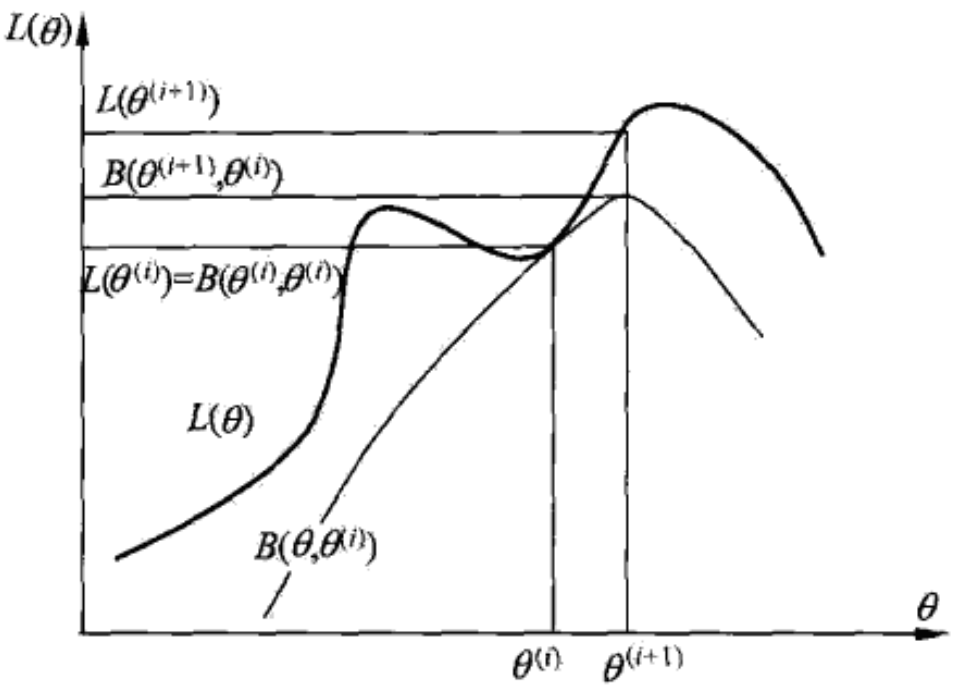

In [9]:
from IPython.display import Image
Image(filename='figures/EM.png', width=500)

Note that $L(\boldsymbol{\theta}) \geq B({\boldsymbol{\theta }},{\boldsymbol{\theta }}^{(i)}) = Q({\boldsymbol{\theta }},{\boldsymbol{\theta }}^{(i)}) + C$, where $L(\boldsymbol{\theta}) \geq B({\boldsymbol{\theta }},{\boldsymbol{\theta }}^{(i)})$ comes from $\textit{Jensen inequality}$ and $C$ is a constant.

### Topic 3: Hidden Markov Model (HMM)

What is HMM?

The HMM is a generative probabilistic model, in which a sequence of observable
$\mathbf{X}$ variables is generated by a sequence of internal hidden
states $\mathbf{Z}$. The hidden states are not observed directly.
The transitions between hidden states are assumed to have the form of a
(first-order) Markov chain. They can be specified by the start probability
vector $\boldsymbol{\pi}$ and a transition probability matrix
$\mathbf{A}$. The emission probability of an observable can be any
distribution with parameters $\boldsymbol{\theta}$ conditioned on the
current hidden state. The HMM is completely determined by the parameter set
$\boldsymbol{\lambda} = (\boldsymbol{\pi}, \mathbf{A}, \boldsymbol{\theta})$.

What are the three fundamental problems for HMMs?

* Given the model parameters and observed data, calculate the likelihood
  of the data $P(\mathbf{X}|\boldsymbol{\lambda})$.
  
* Given just the observed data $\mathbf{X}$, estimate the model parameters $\boldsymbol{\lambda}$.

* Given the model parameters $\boldsymbol{\lambda}$ and observed data $\mathbf{X}$, estimate the optimal
  sequence of hidden states $\mathbf{Z}$ where $P(\mathbf{Z}|\mathbf{X})$ is maximized.

What are the solutions?

* The first problem can be solved by Forward-Backward algorithm.
* The second problem can be solved by an iterative Expectation-Maximization (EM) algorithm, known as the Baum-Welch algorithm.
* The third problem can be solved by dynamic programming algorithms known as the Viterbi algorithm.

Sounds familiar? Recall the procedures of doing Naive Bayes classifier and Gaussian Mixture Models, can you find any similarities?

In [2]:
from hmmlearn import hmm

Notice: The sklearn.hmm module has been deprecated due to it no longer matching the scope and the API of the project. It becomes an independent python package now.

In [ ]:
startprob = np.array([0.6, 0.3, 0.1, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

What is $\boldsymbol{\lambda} = (\boldsymbol{\pi}, \mathbf{A}, \boldsymbol{\theta})$ in this case?

In [ ]:
# Generate samples
X, Z = model.sample(500)

# Plot the sampled data
plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=17, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()

Can you explain why there is no transition between component 1 and component 3 (or component 2 and component 4)?

Refereces:

[1] https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

[2] https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/pca.pdf

[3] https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html

[4] https://github.com/hmmlearn/hmmlearn